This file contains functions to visualize and select the best training curves from our experiments.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('cmu_paper')

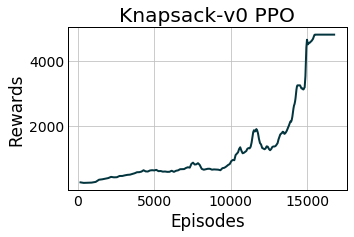

/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da3_1_lr=0.001,vf_share_layers=True_2020-03-21_16-39-26_z6_97l8


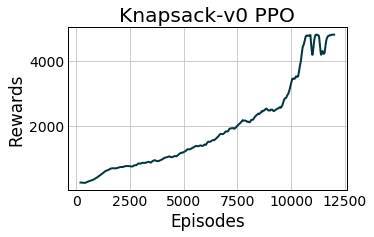

/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da4_2_lr=0.0001,vf_share_layers=True_2020-03-21_17-13-03j4saa4bw


In [29]:
# Get data from results folders
env_path = '../or_gym/benchmarks/'
envs = os.listdir(env_path)
for env in envs:
    try:
        result_path = os.listdir(env_path + env + '/results/')
    except FileNotFoundError:
        continue
    result_data = pd.DataFrame()
    for path in result_path:
        _result_data = pd.read_csv(os.path.join(env_path, env, 'results', path))
        result_data = pd.concat([result_data, _result_data])
        
    top_results = result_data.loc[
        result_data['episode_reward_mean']==result_data['episode_reward_mean'].max()]
    
    for _path in top_results['logdir']:
        algo_name = os.path.basename(_path).split('_')[0]
        train_data = pd.read_csv(_path + '/progress.csv')
        plt.figure(figsize=(5, 3))
        plt.plot(train_data['episodes_total'], train_data['episode_reward_mean'])
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title(path.split('_')[0] + ' ' + algo_name)
        plt.show()
        print(_path)

'PPO_Knapsack-v0_70012da4_2_lr=0.0001,vf_share_layers=True_2020-03-21_17-13-03j4saa4bw'

In [ ]:
os.l

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train_data['episodes_total'], train_data['episode_reward_mean'])
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()